## Scratch

In [69]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs
import tf_lab.point_clouds.in_out as pio
import tf_lab.models.point_net_based_AE as pnAE
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.various_encoders_decoders as enc_dec


from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed,\
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from geo_tool import Point_Cloud

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

In [53]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/1024/')

full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

52103 files containing complete point clouds were found.


/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/in_out.py:64: UserWarning: Point clouds with the same model name were loaded.
  warnings.warn('Point clouds with the same model name were loaded.')


In [82]:
train_data_, val_data_, test_data_ = pio.train_validate_test_split([full_pclouds,                                                             
                                                            full_model_names],
                                                            train_perc=0.8,
                                                            validate_perc=0.1,
                                                            test_perc=0.1,
                                                            seed=seed)



test_data = merge_val_test_data(val_data_, test_data_)

10421

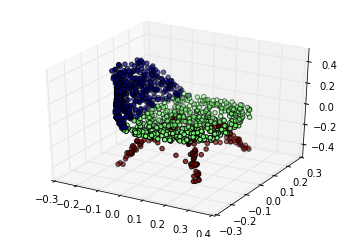

Point Cloud with 1024 points.


In [67]:

DATA_PATH = '/orions4-zfs/projects/lins2/Panos_Space/DATA/SN_with_part_annotation/03001627/expert_verified/points_label/'
model_id = '1015e71a0d21b127de03ab2a27ba7531.seg'
seg_file = osp.join(DATA_PATH, model_id)


DATA_PATH = '/orions4-zfs/projects/lins2/Panos_Space/DATA/SN_with_part_annotation/03001627/points/'
model_id = '1015e71a0d21b127de03ab2a27ba7531.pts'
pts_file = osp.join(DATA_PATH, model_id)





# bool_mask = np.logical_or(c==1, c==2)
# def apply_mask(self, bool_mask):
#     return Point_Cloud(self.points[bool_mask, :])
# apply_mask(pc, bool_mask).plot()

array([[ 0.26109004,  0.09401268, -0.02499332]], dtype=float32)

array([[-0.0246922 ,  0.10568816, -0.11596782]], dtype=float32)

array([False,  True,  True, ...,  True,  True, False], dtype=bool)

In [5]:
file_names = pio.load_filenames_of_input_data(DATA_PATH, verbose=VERBOSE)

all_pclouds, model_names, class_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=15, verbose=VERBOSE)

train_data_, val_data_, test_data_ = pio.train_validate_test_split(
                                                           [all_pclouds,                                                             
                                                            model_names],
                                                            train_perc=0.8,
                                                            validate_perc=0.1,
                                                            test_perc=0.1,
                                                            seed=seed)

trs = set(train_data_[1])
vas = set(val_data_[1])
tes = set(test_data_[1])

assert trs.isdisjoint(vas) and vas.isdisjoint(tes) and tes.isdisjoint(trs)

52103 files were found.
52103 pclouds were loaded. They belong in 50 shape-classes.


/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/in_out.py:64: UserWarning: Point clouds with the same model name were loaded.
  warnings.warn('Point clouds with the same model name were loaded.')


AssertionError: 

In [9]:
train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

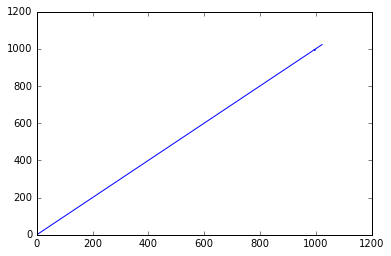

In [6]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


conf =     Conf(n_input = [1024, 3],
               training_epochs = 1000,
               batch_size = 40,
               loss = 'Chamfer',
               train_dir = TRAIN_DIR,
               loss_display_step = 1,
               saver_step = 5,
               learning_rate = 0.00002,
               saver_max_to_keep = 200,
               gauss_augment = {'mu': 0, 'sigma': 0.02},
               encoder = pnAE.encoder,
               decoder = enc_dec.decoder_only_with_fc,
               )
reset_graph()
ae = PointNetAutoEncoder(experiment_name, conf)

## Evaluate

In [7]:
saved_epochs = read_saved_epochs(conf.train_dir)
epochs = saved_epochs[::len(saved_epochs)/10]
stats = eval_model(ae, conf, [train_data, test_data], epochs=epochs, verbose=False)

NameError: name 'train_data' is not defined

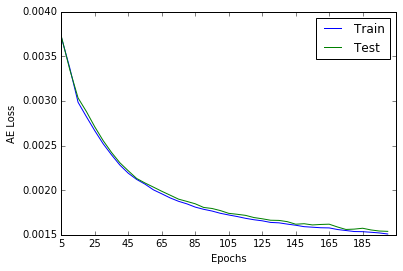

In [16]:
top_save_dir = osp.join('/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/model_evaluation/vanilla_ae', experiment_name)
plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

In [70]:
last_epoch = saved_epochs[-1]
save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)
save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)

In [37]:
# Experimenting with Tensorboard - Visualizations
from tf_lab.fundamentals.inspect import hist_summary_of_trainable
writer = tf.summary.FileWriter('/Users/optas/Desktop/test', ae.graph)
# hist_summary_of_trainable(ae.graph)

In [ ]:
# If you 'merge' Erics pclouds with his segmentations then use.
def read_pcloud_with_segs(in_file):
    in_data = np.loadtxt(in_file)
    pts = in_data[:, [0, 1, 2]]
    seg = in_data[:, 3].astype(np.int32)
    return pts, seg